In [167]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
# read all the words
words= open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [95]:
# build vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [118]:
# build the dataset

block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] #crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [119]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [98]:
C = torch.randn((27,2))

In [76]:
C[5]

tensor([-1.0615, -1.0161])

In [99]:
# one hot has to convert to float as it returns Long Int64
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4054,  0.0609])

In [100]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [101]:
# the inputs to this layer will be 3 * 2, as we have 2d embeddings and 3 of them.
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [102]:
# when -1 is used pytorch will infer what this should be.
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [103]:
h

tensor([[-1.0000,  0.9997,  0.9416,  ..., -0.4261, -0.6153, -0.9999],
        [-1.0000,  0.9966,  0.9928,  ...,  0.9466, -0.2630, -0.9999],
        [-0.8780,  0.7887,  0.9940,  ...,  0.9923, -0.8978, -0.8893],
        ...,
        [ 0.9949, -0.9434,  0.9658,  ...,  0.9740, -0.2531, -0.3435],
        [ 0.9681, -0.3198, -0.7003,  ..., -0.9600, -0.7903,  0.9744],
        [ 0.9288, -0.9632, -0.3570,  ..., -0.8182,  0.9869, -0.8361]])

In [82]:
# explanantion for 'h' process

emb @ W1 + b1 # won't work as emb is [32, 3, 2] and W1 is [6, 100]

# opt 1 : torch.cat()
# won't generalize if we want to change the block size
# creates new tensors and memory, inefficient 
torch.cat([emb[:, 0, :], emb[:, 1,:], emb[:, 2, :]], 1)

# opt 2: torch.cat() with torch.unbind()
torch.cat(torch.unbind(emb, 1), 1)

# opt 3: .view() 'best'


RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [120]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [105]:
logits = h @ W2 + b2

In [106]:
logits.shape

torch.Size([32, 27])

In [107]:
counts = logits.exp()

In [108]:
prob = counts / counts.sum(1, keepdims=True)

In [121]:
prob.shape

torch.Size([32, 27])

In [110]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(19.3736)

In [53]:
#  --------- make more respectable ------------ #

In [126]:
X.shape, Y.shape # dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [169]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [170]:
sum(p.nelement() for p in parameters) # number of total parameters

3481

In [171]:
for p in parameters:
    p.requires_grad = True

In [130]:
for _ in range(10):
    # forward pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #(32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.084514617919922
15.776554107666016
14.833368301391602
14.002623558044434
13.253271102905273
12.579926490783691
11.983112335205078
11.470507621765137
11.051870346069336


In [63]:
# Info only
# forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

In [66]:
# Info only
# more efficient than manually getting the counts, prob and loss calc. 
F.cross_entropy(logits, Y)

tensor(17.7697)

In [131]:
# Info only
# If we have very positive logits, ex. 100, we run out of range in out floating point number. e**100
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
prob = counts / counts.sum()
prob

tensor([0., 0., 0., nan])

In [162]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [182]:
# using mini-batches

lri = []
lossi = []

# the quality of the grad is lower, the grad direction is not exact but it is god enough. 
# It is much better to have an approx gradiant and make more steps. than calc the exact grad and make fewer steps.
# That's why it works quite well in practice.
# using learning decay, going from 0.1 -> 0.01 -> 0.001
for i in range(10000):

    # mini batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) #(32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.001
    for p in parameters:
        # p.data += -0.1 * p.grad
        p.data += -lr * p.grad
    
    # track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.067655324935913


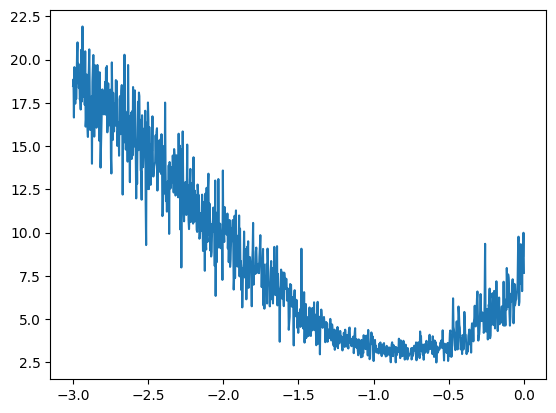

In [174]:
plt.plot(lri, lossi)